## 2. Nonstationary Bandit
The k-armed bandit problem in 'simple_bandit.ipynb) was stationary in that the expected reward for taking an action did not change with time (i.e. the mean and variance was fixed). In some problems, it is possible that the expected reward changes with time. Such problems are said to be nonstationary

From the incremental update rule,
\begin{align}
Q_{n+1} & = Q_n + \alpha[R_n - Q_n] \\
& = \alpha R_n + (1 - \alpha)Q_n \\
& = \alpha R_n + (1 - \alpha)\left[\alpha R_{n-1} + (1-\alpha)Q_{n-1} \right] \\
& = \alpha R_n + (1 - \alpha)\alpha R_{n-1} + (1-\alpha)^2Q_{n-1} \\
& = \alpha R_n + (1 - \alpha)\alpha R_{n-1} + (1-\alpha)^2\alpha R_{n-2} + ... + (1-\alpha)^{n-1}\alpha R_1 + (1-\alpha)^n Q_1 \\
& = (1-\alpha)^n Q_1 + \sum_{i=1}^n \alpha(1-\alpha)^{n-i} R_i
\end{align}

This is called a **weighted average**. Note that the weight given to a previous reward decays exponentially as the number of intervening rewards increases. $\alpha$ is called the step-size parameter. How do we set $\alpha$? In some cases, it is conveneint to vary it with time. Let $\alpha_n(a)$ denote the step-size parameter used to process the reward received after the nth selection of action a. In the sample average method, $\alpha_n(a) = \frac{1}{n}$. Another often used variant is the constant step-size parameter, $\alpha_n(a) = \alpha$.

Below we investigate the effect of $\alpha$ on the performance of an agent in a nonstationary k-armed bandit problem.

#### Exercise 2.3  $^1$
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks. Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed by $\alpha = \frac{1}{n}$, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and if necessary, runs longer than 1000 steps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sample_average_step_size(N, i):
    """
    :param N: N[i] is the no. of times action i has been executed
    :param i: The index of the selected action
    """
    return 1.0 / N[i]

def constant_step_size(N, i):
    return 0.1

In [3]:
def get_reward(true_values, a):
    """
    Returns the reward for selecting action a.
    Reward is selected around true_values[a] with unit variance (as in problem description)
    :param true_values: true_values[i] is the expected reward for action i
    :param a: index of action to return reward for
    """
    reward = np.random.normal(true_values[a], size=1)[0]
    return reward

In [4]:
def random_walk(true_values):
    """
    Updates each expected reward by random amounts to imitate a nonstationary reward
    :param true_values: true_values[i] is the expected reward for action i
    """
    true_values += np.random.uniform(-1.0, 1.0, true_values.shape)

In [5]:
# We get rid of the sample_average() method and modify k_armed_bandit as follows:
def k_armed_bandit(k, epsilon, iterations, step_fn):
    """
    Performs a single run of the k-armed bandit experiment
    :param k: the number of arms
    :param epsilon: Value of epsilon for epoch-greedy action selection
    :param iterations: number of steps in a single run
    :param step_fn: step-size function
    """
    # Equal action values at start
    true_values = np.ones(k) * np.random.uniform(-1.0, 1.0)
    
    # Estimates of action values
    Q = np.zeros(k)

    # N[i] is the no. of times action i has been taken
    N = np.zeros(k)
    
    # Store the rewards received for this experiment
    rewards = []
    
    # Track how often the optimal action was selected
    optimal = []
    
    for _ in range(iterations):
        prob = np.random.rand(1)
        
        if prob > epsilon:
            # Greedy (exploit current knowledge)
            a = np.random.choice(np.flatnonzero(Q == Q.max()))
        else:
            # Explore (take random action)
            a = np.random.randint(0, k)
            
        reward = get_reward(true_values, a)        
        
        # Update statistics for executed action
        N[a] += 1
        Q[a] += step_fn(N, a) * (reward - Q[a])
        
        rewards.append(reward)
        optimal.append(1 if a == true_values.argmax() else 0)
        
        # Update the rewards after each step
        random_walk(true_values)
    
    return rewards, optimal

In [6]:
def experiment(k, epsilon, iters, epochs, step_fn):
    """
    Runs the k-armed bandit experiment
    :param k: the number of arms
    :param epsilon: the value of epsilon for epoch-greedy action selection
    :param iters: the number of steps in a single run
    :param epochs: the number of runs to execute
    :param step_fn: the step-size function
    """
    rewards = []
    optimal = []
    
    for i in range(epochs):
        r, o = k_armed_bandit(k, epsilon, iters, step_fn)
        rewards.append(r)
        optimal.append(o)
        
    print('Experiment with \u03b5 = {} completed.'.format(epsilon))
    
    # Compute the mean reward for each iteration
    r_means = np.mean(rewards, axis=0)
    o_means = np.mean(optimal, axis=0)
    
    return r_means, o_means

In [7]:
k = 10
epsilon = 0.1
iters = 5000
runs = 2000

# Experiment with sample-average step-size and constant step-size
r_exp1, o_exp1 = experiment(k, epsilon, iters, runs, sample_average_step_size)
r_exp2, o_exp2 = experiment(k, epsilon, iters, runs, constant_step_size)

Experiment with ε = 0.1 completed.
Experiment with ε = 0.1 completed.


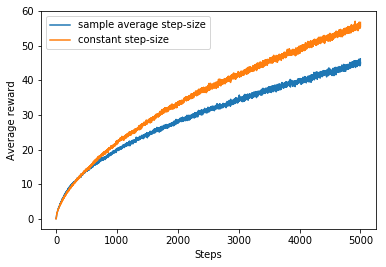

In [8]:
x = range(iters)
plt.plot(x, r_exp1, label='sample average step-size')
plt.plot(x, r_exp2, label='constant step-size')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

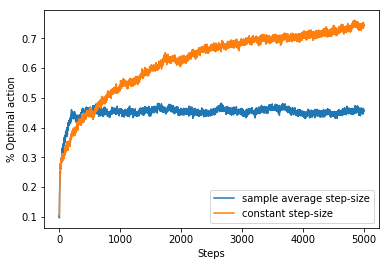

In [9]:
plt.plot(x, o_exp1, label='sample average step-size')
plt.plot(x, o_exp2, label='constant step-size')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

The results show that indeed, the sample average method suffers when used in a nonstationary environment. As n increases, the update to Q[a] decreases and so our estimates suffer leading to poor results.

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.